# Milestone 3: Text analysis
The hypothesis behind this model was that the textual information about movies would be predictive of the genres. In order to model this, we used a Dirichlet multinomial Bayesian model. 

In [74]:
%matplotlib inline

import os
import re
import nltk
import random
import itertools
import numpy as np
import pandas as pd
from collections import Counter
from unidecode import unidecode
from nltk.corpus import stopwords
from collections import OrderedDict
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score

plt.style.use('ggplot')
random.seed(42)

## Grabbing the data
For now, we have a total sample of around 50,000 movies. For this model, however, we worked with a random sample of 5,000 films. We also only looked at the textual data (`overview` and `reviews`) and the list of genres (`genres`). 

In [18]:
raw = pd.read_json('https://s3.amazonaws.com/cs109b-data/training_4-29.json')
print(raw.shape)

# Keeping only genres, overviews, and reviews
raw = raw[list(raw.columns[0:20]) + ['overview']].copy()
print(raw.shape)
raw.head()

(9549, 47)
(9549, 21)


,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,Foreign,...,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western,overview
0,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,Modern industrialization is no longer about st...
1,False,False,False,False,False,True,False,False,False,False,...,False,False,False,False,False,False,False,False,False,The documentary is an analysis of the fascinat...
2,True,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,A good-natured kung fu kid gets caught up in c...
3,True,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,In Los Angeles a deadly plague called the 'Pan...
4,True,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,True,False,False,In Los Angeles a deadly plague called the 'Pan...


## Determining $y$: Flattening `genres` into `genre`

In [25]:
genres = [x for x in raw.columns[0:20]]

def genre_lists(row):
    row['genre_list'] = []
    for genre in genres:
        if row[genre] == True:
            row['genre_list'].append(genre)
    return row

raw = raw.apply(lambda x: genre_lists(x), axis = 1)
raw = raw[['overview', 'genre_list']]
print(raw.shape)
raw.head()

(9549, 2)


,overview,genre_list
0,Modern industrialization is no longer about st...,[Documentary]
1,The documentary is an analysis of the fascinat...,[Documentary]
2,A good-natured kung fu kid gets caught up in c...,[Action]
3,In Los Angeles a deadly plague called the 'Pan...,"[Action, Drama, Thriller]"
4,In Los Angeles a deadly plague called the 'Pan...,"[Action, Drama, Thriller]"


In [27]:
all_bigrams_ever = []

def bigrams(row):
    return zip(row['genre_list'], row['genre_list'][1:])

def col_for_each_bigram(row):
    for bigram in row['genre_bigrams']:            
        all_bigrams_ever.append(tuple(sorted(bigram)))
    return row

def popular_bigram(row):
    for k in row['genre_bigrams']:
        #if bigram_frequency[k] <= 50 and len(row['genre_lists']) != 1:
            #row['popular_bigram'] = 'Other'
        if k in OrderedDict(bigram_frequency.most_common()).keys() and row['popular_bigram'] != k:
            row['popular_bigram'] = k
    if len(row['genre_list']) == 1:
        row['popular_bigram'] = tuple(row['genre_list'])
    return row
                
for i in range(raw.shape[0]):
    raw.loc[i, 'genre_list'].sort()

raw['genre_bigrams'] = raw.apply(lambda x: bigrams(x), axis = 1)
raw['popular_bigram'] = np.nan
raw = raw.apply(lambda x: col_for_each_bigram(x), axis = 1)
bigram_frequency = Counter(all_bigrams_ever)

raw = raw.apply(lambda x: popular_bigram(x), axis = 1)
raw.head()

,overview,genre_list,genre_bigrams,popular_bigram
0,Modern industrialization is no longer about st...,[Documentary],[],"(Documentary,)"
1,The documentary is an analysis of the fascinat...,[Documentary],[],"(Documentary,)"
2,A good-natured kung fu kid gets caught up in c...,[Action],[],"(Action,)"
3,In Los Angeles a deadly plague called the 'Pan...,"[Action, Drama, Thriller]","[(Action, Drama), (Drama, Thriller)]","(Drama, Thriller)"
4,In Los Angeles a deadly plague called the 'Pan...,"[Action, Drama, Thriller]","[(Action, Drama), (Drama, Thriller)]","(Drama, Thriller)"


In [36]:
genre_big = pd.DataFrame(raw.groupby(['popular_bigram'])['overview'].count())
genre_big = genre_big.reset_index()
genre_big['prop'] = genre_big['overview']/genre_big['overview'].sum()
genre_big2 = genre_big[genre_big['prop'] < 0.01]
genre_big.shape, genre_big2.shape

((176, 3), (153, 3))

In [37]:
raw['popular_bigram2'] = raw['popular_bigram']
for i in range(raw.shape[0]):
    if raw.loc[i, 'popular_bigram'] in list(genre_big2['popular_bigram']):
        raw.loc[i, 'popular_bigram2'] = 'Other'
        
genre_frequency = raw['popular_bigram2'].value_counts()
genre_frequency

Other                          3601
(Documentary,)                  667
(Drama, Romance)                500
(Drama, Thriller)               485
(Horror, Thriller)              468
(Drama,)                        462
(Comedy,)                       347
(Science Fiction, Thriller)     316
(Comedy, Drama)                 294
(Mystery, Thriller)             280
(Comedy, Romance)               193
(Documentary, Music)            189
(Crime, Drama)                  182
(Drama, Family)                 175
(Horror,)                       171
(Romance, Thriller)             165
(Horror, Science Fiction)       161
(Crime, Thriller)               156
(Comedy, Family)                146
(Animation, Family)             140
(Music,)                        131
(Comedy, Horror)                119
(Family, Fantasy)               105
(Action, Thriller)               96
Name: popular_bigram2, dtype: int64

In [42]:
# Number of unique movies
raw['overview'].nunique()

4866

In [104]:
df = raw[(raw['popular_bigram2'] != 'Other') & (raw['overview'] != False)][['popular_bigram2', 'overview']].drop_duplicates().copy()
print(df.shape)
df.head()

(3324, 2)


,popular_bigram2,overview
0,"(Documentary,)",Modern industrialization is no longer about st...
1,"(Documentary,)",The documentary is an analysis of the fascinat...
3,"(Drama, Thriller)",In Los Angeles a deadly plague called the 'Pan...
10,"(Comedy, Romance)",When Apollo finds himself surrounded by friend...
13,"(Music,)",The DVD release of the band's performance at M...


In [31]:
# # Downsampling drama and comedy movies
# index_to_drop = df[(df['genre'] == 'Drama') | (df['genre'] == 'Comedy')].sample(frac = 0.0)

# df2 = df.drop(index_to_drop.index).copy()
# print(df.shape, df2.shape)
# df2['genre'].value_counts()

((9397, 2), (9397, 2))


Drama              1738
Comedy             1203
Documentary         905
Thriller            851
Action              675
Horror              638
Romance             516
Crime               373
Science Fiction     347
Family              340
Music               329
Adventure           312
Animation           266
Mystery             204
Fantasy             202
TV Movie            162
History             107
Foreign              99
War                  70
Western              60
Name: genre, dtype: int64

## Converting `overview` to word-frequency vectors
For movie overviews, we turned these into word-frequency vectors. 

In [105]:
# I realized that sometimes 'overview' was in my top words list; renaming it here 'protects' it
df.rename(columns={'overview': 'movie_overview'}, inplace=True)

stops = set(nltk.corpus.stopwords.words('english'))
all_words_ever = []

def add_cols_for_all_words(row):
    if row['movie_overview'] is not None:
        words = nltk.word_tokenize(row['movie_overview'])
        words = [word.lower() for word in words if len(word) > 2 and unidecode(word.lower()) not in stops]
        all_words_ever.extend(words)
    return row

def parse_words(row):
    if row['movie_overview'] is not None:
        words = nltk.word_tokenize(row['movie_overview'])
        words = [word.lower() for word in words if word.lower() in top_words]
        for word in words:
            row[unidecode(word)] += 1        
    return row

In [106]:
df = df.apply(lambda x: add_cols_for_all_words(x), axis = 1)
len(all_words_ever), len(set(all_words_ever))

(104581, 20804)

## Fitting the model
We have identified around 20,000 unique words that appear, globally, across all the movie summaries. We cannot use all 20,000 word vectors, as we would then have the "curse of dimensionality" - an incredibly sparse matrix. Instead, following the Dirichlet homework, we only selected the most frequently occurring words as columns. Since this was akin to a tuning parameter, we cross-validated to find the optimal number of word vectors to include.

In [107]:
# Initialize model object
clf = MultinomialNB()

In [109]:
word_scores = []

for top_word_count in range(100, 1000, 300):
    top_words = [word[0] for word in Counter(all_words_ever).most_common(top_word_count)]
    for word in top_words:
        df[unidecode(word)] = 0

    this_df = pd.DataFrame()
    this_df = df.apply(lambda x: parse_words(x), axis = 1)

    X = this_df[this_df.columns[-top_word_count:]]
    y = this_df['popular_bigram2']
    y = y.apply(lambda x: str(x))
    print(X.shape, y.shape)

    scores = cross_val_score(clf, X, y, cv=5)
    word_scores.append({'top_word_count': top_word_count, 'average_score': scores.mean()})

word_scores = pd.DataFrame(word_scores)
word_scores.head()

((3324, 100), (3324,))
((3324, 400), (3324,))
((3324, 700), (3324,))


,average_score,top_word_count
0,0.293384,100
1,0.319222,400
2,0.335198,700


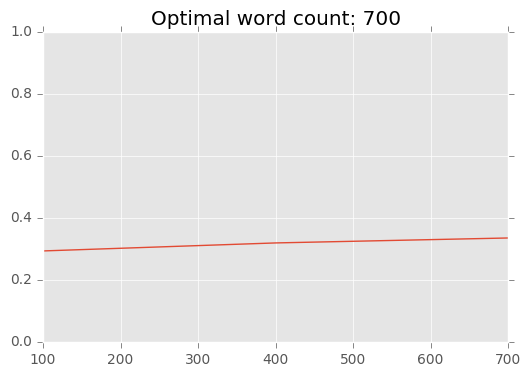

In [110]:
best_word_count = word_scores[word_scores['average_score'] == word_scores['average_score'].max()]['top_word_count'].item()

plt.plot(word_scores['top_word_count'], word_scores['average_score'])
plt.title('Optimal word count: {}'.format(best_word_count))
plt.ylim([0,1])
plt.show()

<hr>

### Confusion matrix
Note: Validation set is completely unseen data.

In [139]:
best_df = df.apply(lambda x: parse_words(x), axis = 1)
train = best_df.copy()
train.shape

(3324, 702)

In [141]:
len(top_words), top_words[0:10]

(700,
 [u'life',
  u'one',
  u'new',
  u'film',
  u'world',
  u'young',
  u'two',
  u'man',
  u'story',
  u'family'])

In [142]:
test = pd.read_json('https://s3.amazonaws.com/cs109b-data/testing_4-29.json')

# Genre bigrams
test = test.apply(lambda x: genre_lists(x), axis = 1)
test['genre_bigrams'] = test.apply(lambda x: bigrams(x), axis = 1)
test['popular_bigram'] = np.nan
test = test.apply(lambda x: popular_bigram(x), axis = 1)
test['popular_bigram2'] = test['popular_bigram']
for i in range(test.shape[0]):
    if test.loc[i, 'popular_bigram'] in list(genre_big2['popular_bigram']):
        test.loc[i, 'popular_bigram2'] = 'Other'
test2 = test[(test['popular_bigram2'] != 'Other') & (test['overview'] != False)][['popular_bigram2', 'overview']].drop_duplicates().copy()

# NLP
test2.rename(columns = {'overview': 'movie_overview'}, inplace=True)

for word in top_words:
    test2[unidecode(word)] =  0

# test2 = test2.apply(lambda x: add_cols_for_all_words(x), axis = 1)
test2 = test2.apply(lambda x: parse_words(x), axis = 1)
print(test2.shape)
test2.head()

(1245, 702)


,popular_bigram2,movie_overview,life,one,new,film,world,young,two,man,...,scientist,questions,mike,member,rare,professor,rich,innocent,complete,adam
0,"(Action, Thriller)",An elite Federal force whose objective is to e...,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"(Comedy, Family)",When the sky really is falling and sanity has ...,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,"(Drama, Romance)","A witty, romantic, and very dangerous love sto...",0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,"(Documentary,)",When Montana couple Bruce Weide and Pat Tucker...,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
5,"(Action, Thriller)",A sheriff (C. Thomas Howell) tries to save uns...,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [143]:
X_train = train[train.columns[-best_word_count:]]
X_test = test2[test2.columns[-best_word_count:]]
y_train = train['popular_bigram2'].apply(lambda x: str(x))
y_test = test2['popular_bigram2'].apply(lambda x: str(x))
X_train.shape, X_test.shape

((3324, 700), (1245, 700))

In [144]:
fitted = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)
score = fitted.score(X_test, y_test)
cm = confusion_matrix(y_test, y_pred, labels = y_test.unique())

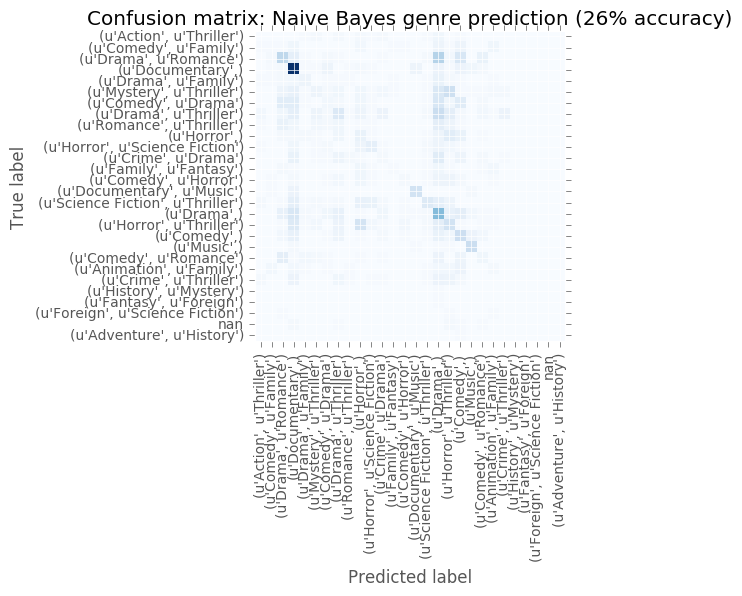

In [145]:
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
tick_marks = np.arange(y_test.nunique())
plt.xticks(tick_marks, y_test.unique(), rotation=90)
plt.yticks(tick_marks, y_test.unique())
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion matrix: Naive Bayes genre prediction ({:.0f}% accuracy)'.format(score*100))
plt.show()